In [8]:
import pandas as pd
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt

In [17]:
data = pd.read_csv("saved/comments_with_sentitment.csv")

In [18]:
data.head(1000).tail(10)

,authorDisplayName,comment,sentiment
990,@artoo45,Lose the AC/gas heat and get a heat pump.,neutral
991,@gigi-fe3nd,You forgot to count the fridge.,negative
992,@ozchalupkova4688,120000 usd 😱 I burn 12000kwh yearly and pay 13...,negative
993,@Skm97815,Did he just spend 3 minutes explaining why sol...,neutral
994,@drpc98014,In a perfect world your examples may be valid....,negative
995,@mewkiki0,Is it me or does he keep changing the thumbnai...,neutral
996,@ShouldiBuyABoat,"yeah u havent paid for electricity for a year,...",negative
997,@youneverknow1536,Think the government throws some money at you...,negative
998,@TMJ32,If absolutely every single house in any given ...,negative
999,@slipperyslope3912,Bro this is so dumb. Your overnight rate is $0...,negative


In [6]:
data["sentiment"].value_counts()

sentiment
neutral     10417
positive     7718
negative     7650
unknown        47
Name: count, dtype: int64

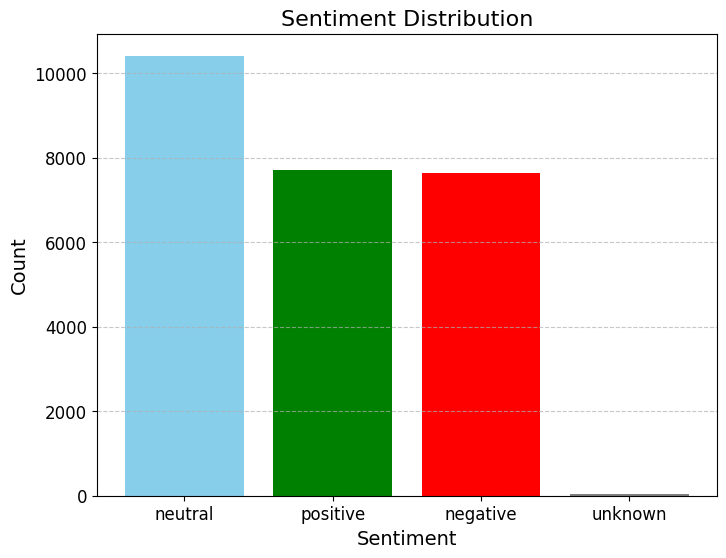

In [10]:
# Plot with different colors
sentiment_counts=data["sentiment"].value_counts()
colors = ['skyblue', 'green', 'red', 'gray']

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display
plt.show()

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
def get_entities(text):
    doc = nlp(text)
    list_ = []
    for ent in doc.ents:
        if ent.label_.lower() not in ("cardinal"):
            tmp = re.sub("[^a-z0-9]+",'_',ent.text.lower())
            list_.append('_'.join([tmp,ent.label_.upper()]))
        
    return ' '.join(list_)        
   

In [13]:
get_entities("Many videos on youtube talk about how crappy Tesla solar systems are. You're better off waiting, since the new solar panels will be out next year and are more than 10x for efficient and cost much less as well. If you don't want to wait because you're one of these frontal lobe damaged impatient people, then you do you, but I'm waiting till next year and will be paid off and more efficient before you're even half way.")

'tesla_ORG next_year_DATE next_year_DATE'

In [15]:
data["entities"]=np.vectorize(get_entities)(data.comment)

In [ ]:
1000699327059

In [22]:
edata = data[["sentiment","entities"]]

In [23]:
edata.head(20)

,sentiment,entities
0,negative,tesla_ORG double_ORG a_month_DATE __ORG
1,negative,srec_ORG
2,neutral,twitter_PERSON
3,neutral,a_day_DATE _40kw_NORP kwp_ORG
4,neutral,__PERSON
5,positive,tesla_ORG
6,neutral,9_600_MONEY annual_DATE about_20_years_DATE 54...
7,negative,4500_MONEY 9000_MONEY 100k_PRODUCT 10_years_DA...
8,negative,100__PERCENT ev_ORG 20_year_DATE _mkbhd_ORG
9,negative,100__PERCENT arizona_GPE summer_DATE 24_hours_...


In [36]:
# Séparer les entités en lignes individuelles
edata = edata.assign(entities=edata['entities'].str.split()).explode('entities').reset_index(drop=True)

# Extraire les colonnes `entity` et `entity_type` à partir des entités
edata[['entity', 'entity_type']] = edata['entities'].str.rsplit('_', n=1, expand=True)

# Supprimer les lignes où les entités sont NaN (liées à des commentaires vides)
edata = edata.dropna(subset=['entities'])

# Grouper et calculer les statistiques
result = edata.groupby(['entity', 'entity_type']).agg(
    total_comments=('sentiment', 'count'),
    positive=('sentiment', lambda x: (x == 'positive').sum()),
    negative=('sentiment', lambda x: (x == 'negative').sum()),
    neutral=('sentiment', lambda x: (x == 'neutral').sum())
).reset_index()

# Ajouter les colonnes supplémentaires
result['delta'] = result['positive'] - result['negative']
result['true_ratio'] = result['positive'] / result['total_comments']

# Trier les résultats par total_comments en ordre décroissant
result = result.sort_values(by='total_comments', ascending=False)

# Afficher le résultat final
result.head(10)

,entity,entity_type,total_comments,positive,negative,neutral,delta,true_ratio
10138,tesla,ORG,1684,500,518,617,-18,0.296912
4977,ac,ORG,679,165,162,340,3,0.243004
337,10_years,DATE,571,84,232,251,-148,0.147110
8348,monthly,DATE,563,77,184,286,-107,0.136767
11408,winter,DATE,457,105,108,214,-3,0.229759
6616,ev,ORG,428,114,133,163,-19,0.266355
11217,us,GPE,402,70,159,167,-89,0.174129
6809,first,ORDINAL,338,108,96,127,12,0.319527
9999,summer,DATE,303,77,72,143,5,0.254125
11129,uk,GPE,276,65,100,109,-35,0.235507


In [37]:
result["entity_type"].value_counts()

entity_type
DATE        3385
MONEY       2006
ORG         1772
PERSON      1113
GPE          650
QUANTITY     624
TIME         600
PERCENT      429
PRODUCT      270
NORP         235
LOC          161
ART          128
ORDINAL       99
FAC           56
LAW           35
EVENT         28
LANGUAGE       7
Name: count, dtype: int64

In [38]:
result[result["entity_type"]=="DATE"].head(20)

,entity,entity_type,total_comments,positive,negative,neutral,delta,true_ratio
337,10_years,DATE,571,84,232,251,-148,0.147110
8348,monthly,DATE,563,77,184,286,-107,0.136767
11408,winter,DATE,457,105,108,214,-3,0.229759
9999,summer,DATE,303,77,72,143,5,0.254125
4540,a_year,DATE,262,48,120,88,-72,0.183206
10348,the_day,DATE,226,45,54,121,-9,0.199115
1648,25_years,DATE,223,18,89,108,-71,0.080717
10800,the_summer,DATE,218,51,61,102,-10,0.233945
10860,the_winter,DATE,206,36,57,103,-21,0.174757
10880,the_year,DATE,198,47,51,90,-4,0.237374


In [39]:
result[result["entity_type"]=="MONEY"].head(20)

,entity,entity_type,total_comments,positive,negative,neutral,delta,true_ratio
2931,5_75,MONEY,206,43,71,87,-28,0.208738
0,0,MONEY,153,36,54,56,-18,0.235294
3401,800,MONEY,107,1,83,22,-82,0.009346
189,100k,MONEY,95,12,37,45,-25,0.126316
3816,_,MONEY,65,16,19,25,-3,0.246154
2688,5,MONEY,54,10,21,22,-11,0.185185
3643,92_000,MONEY,52,1,31,20,-30,0.019231
148,100_000,MONEY,49,12,23,11,-11,0.244898
1207,200,MONEY,48,4,26,18,-22,0.083333
110,100,MONEY,44,6,27,11,-21,0.136364


In [29]:
result[result["entity_type"]=="ORG"].head(20)

,entity,entity_type,total_comments,positive,negative,neutral,delta,true_ratio
10138,tesla,ORG,1684,500,518,617,-18,29.691211
4977,ac,ORG,679,165,162,340,3,24.300442
6616,ev,ORG,428,114,133,163,-19,26.635514
5286,apollo,ORG,194,135,33,26,102,69.587629
8732,nj,ORG,98,22,31,45,-9,22.448980
11555,youtube,ORG,92,52,20,19,32,56.521739
3818,_,ORG,78,41,20,16,21,52.564103
7626,kwh,ORG,61,16,21,21,-5,26.229508
9305,powerwall,ORG,47,14,6,24,8,29.787234
4178,_mkbhd,ORG,43,18,10,15,8,41.860465


In [40]:
et_result = (
    result.groupby(["entity_type"])
    .agg(
        total_comments=("total_comments", "sum"),
        positive=("positive", "sum"),
        negative=("negative", "sum"),
        neutral=("neutral", "sum"),
        delta_positive_negative=("delta","sum")
    )
    .reset_index()
).sort_values(by="total_comments",ascending=False)
et_result.head(20)

,entity_type,total_comments,positive,negative,neutral,delta_positive_negative
1,DATE,13169,2654,4442,5672,-1788
11,ORG,7099,2119,2033,2755,86
8,MONEY,4928,716,2128,1936,-1412
4,GPE,4854,1173,1632,1988,-459
13,PERSON,2465,693,693,1031,0
12,PERCENT,1515,281,517,632,-236
9,NORP,1447,263,630,528,-367
16,TIME,1244,264,302,627,-38
14,PRODUCT,1038,233,340,436,-107
15,QUANTITY,843,151,297,326,-146


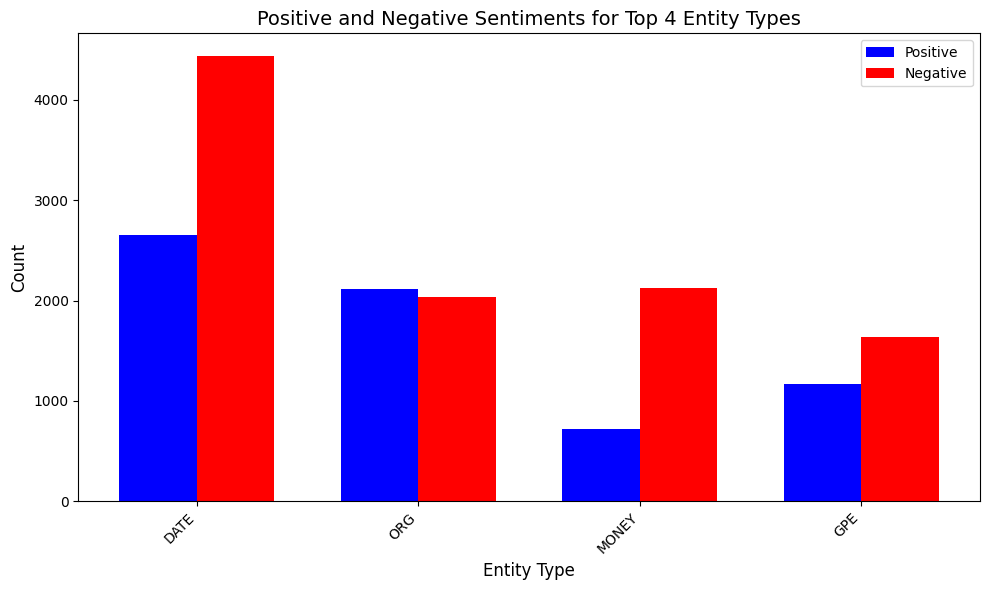

In [41]:

# Plot bar chart for the top 4 entity types with positive and negative bars side by side
top_4=et_result.head(4)
x = range(len(top_4))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([pos - width/2 for pos in x], top_4['positive'], width, label='Positive', color='blue')
ax.bar([pos + width/2 for pos in x], top_4['negative'], width, label='Negative', color='red')

# Add labels and titles
ax.set_xlabel('Entity Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Positive and Negative Sentiments for Top 4 Entity Types', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(top_4['entity_type'], rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()